In [476]:
# Import all required libraries

import nltk
import numpy as np
import re
import pandas as pd 
import pylab as pl
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
#from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot

#plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

#!pip install datashader
import datashader as ds
import datashader.transfer_functions as tf


In [477]:
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream


import tweepy


import twitter_credentials
import numpy as np
import pandas as pd


class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth


class TwitterStreamer():

    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()

    def stream_tweets(self, hash_tag_list):

        listener = TwitterListener()
        auth = self.twitter_autenticator.authenticate_twitter_app()
        stream = Stream(auth, listener)


        stream.filter(track=hash_tag_list)

class TweetAnalyzer():

    def tweets_to_data_frame(self, tweets):
        #for tweet in tweets:
            #print(tweet.full_text)

        df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.full_text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = tweepy.Cursor(api.search, q=['Covishield','Covaxin'], lang="en",
                           tweet_mode='extended').items(1500)
    list_tweets = [tweet for tweet in tweets]

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(list_tweets)

    print(df.head(10))
    #print(df['Tweets'])


                                              Tweets                   id  \
0  RT @VincentRK: Sputnik V vaccine recommended f...  1381682564436389894   
1  RT @MalikAshok: The idea that the market can i...  1381681033041563652   
2  RT @saahilmenghani: #Verified\n\n👉Good news fo...  1381681022912188417   
3  RT @airnewsalerts: Expert panel of Central dru...  1381680892486119427   
4  RT @swapneilparikh: Very important for the pos...  1381680346517757956   
5  RT @saahilmenghani: #Verified\n\n👉Good news fo...  1381680054783074308   
6  @Jaythirdattempt @therightside42 @Indian554960...  1381679946570010638   
7  RT @CovidVaxVictims: I think this lady might t...  1381679794300026882   
8  Experts clear Russia’s Sputnik Covid-19 vaccin...  1381679679631855616   
9  @KhaniQ @mitchierulez @emilymshields It is. Th...  1381679570328424448   

   len                date               source  likes  retweets  
0  138 2021-04-12 18:56:08   Twitter for iPhone      0        17  
1  140 2021-04-12 

In [478]:
df.head(2)

,Tweets,id,len,date,source,likes,retweets
0,RT @VincentRK: Sputnik V vaccine recommended f...,1381682564436389894,138,2021-04-12 18:56:08,Twitter for iPhone,0,17
1,RT @MalikAshok: The idea that the market can i...,1381681033041563652,140,2021-04-12 18:50:03,Twitter for iPhone,0,679


In [479]:
# Number of users with multiple tweets

df["id"].value_counts(ascending=False).head(2)

1381547513442791427    1
1381508788222525442    1
Name: id, dtype: int64

In [480]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [481]:
df['Clean_text'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")

In [482]:
# remove special characters, numbers, punctuations
df['Clean_text'] = df['Clean_text'].str.replace("[^a-zA-Z#]", " ")

<ipython-input-482-46be3fd0461e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Clean_text'] = df['Clean_text'].str.replace("[^a-zA-Z#]", " ")


In [483]:
df['Clean_text'] = df['Clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [484]:
tokenized_tweet = df['Clean_text'].apply(lambda x: x.split())

In [485]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [sputnik, vaccin, recommend, approv, expert, c...
1    [idea, that, market, import, pfizer, moderna, ...
2    [#verifi, good, news, indian, citizen, india, ...
3    [expert, panel, central, drug, regul, dcga, re...
4    [veri, import, post, pandem, period, when, cov...
Name: Clean_text, dtype: object

In [486]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['Clean_text'] = tokenized_tweet

In [487]:
df.loc[:,('Tweets','Clean_text')]

,Tweets,Clean_text
0,RT @VincentRK: Sputnik V vaccine recommended f...,sputnik vaccin recommend approv expert committ...
1,RT @MalikAshok: The idea that the market can i...,idea that market import pfizer moderna rich th...
2,RT @saahilmenghani: #Verified\n\n👉Good news fo...,#verifi good news indian citizen india get vac...
3,RT @airnewsalerts: Expert panel of Central dru...,expert panel central drug regul dcga recommend...
4,RT @swapneilparikh: Very important for the pos...,veri import post pandem period when covid risk...
...,...,...
1495,RT @umasudhir: This is #JustTooCute ... #Keral...,thi #justtoocut #kerala govt video #promotingv...
1496,"RT @FaheemYounus: Sinopharm, Covaxin, Sputnik,...",sinopharm covaxin sputnik covishield sinovac w...
1497,Vaccines approved:\n\nUSA\n* #Pfizer \n* #Mode...,vaccin approv #pfizer #moderna #johnsonandjohn...
1498,"RT @FaheemYounus: Sinopharm, Covaxin, Sputnik,...",sinopharm covaxin sputnik covishield sinovac w...


In [488]:
df[df.Tweets.isnull()]


,Tweets,id,len,date,source,likes,retweets,Clean_text


In [489]:
df[df.Clean_text.isnull()]

,Tweets,id,len,date,source,likes,retweets,Clean_text


In [490]:
# Number of unique tweets
unique_clean_text = df.Clean_text.unique()
unique_full_text = df.Tweets.unique()
print(len(unique_clean_text))
print(len(unique_full_text))
print(len(df))

574
606
1500


In [491]:
df.drop_duplicates(subset=['Clean_text'], keep = 'first',inplace= True)

In [492]:
df.reset_index(drop=True,inplace=True)

In [493]:
df['Clean_text_length'] = df['Clean_text'].apply(len)
df.head()

,Tweets,id,len,date,source,likes,retweets,Clean_text,Clean_text_length
0,RT @VincentRK: Sputnik V vaccine recommended f...,1381682564436389894,138,2021-04-12 18:56:08,Twitter for iPhone,0,17,sputnik vaccin recommend approv expert committ...,88
1,RT @MalikAshok: The idea that the market can i...,1381681033041563652,140,2021-04-12 18:50:03,Twitter for iPhone,0,679,idea that market import pfizer moderna rich th...,76
2,RT @saahilmenghani: #Verified\n\n👉Good news fo...,1381681022912188417,140,2021-04-12 18:50:00,Twitter for Android,0,201,#verifi good news indian citizen india get vac...,83
3,RT @airnewsalerts: Expert panel of Central dru...,1381680892486119427,138,2021-04-12 18:49:29,Twitter for Android,0,41,expert panel central drug regul dcga recommend...,86
4,RT @swapneilparikh: Very important for the pos...,1381680346517757956,140,2021-04-12 18:47:19,Twitter for iPhone,0,1,veri import post pandem period when covid risk...,89


In [494]:
from textblob import TextBlob

In [495]:
TextBlob('Covasheild seems to be useless as people are turning positive even after taking the first dose.').sentiment

Sentiment(polarity=-0.007575757575757569, subjectivity=0.3595959595959595)

In [496]:
c=TextBlob("Covasheild seems to be useless as people are turning positive even after taking the first dose.")

In [497]:
def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

In [498]:
def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [499]:
df['sentiment']=df.Clean_text.apply(calculate_sentiment)
df['sentiment_analyser']=df.Clean_text.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(df)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(df)): 
  s['compound_score'][i] = df['sentiment_analyser'][i]['compound']
  
  if (df['sentiment_analyser'][i]['compound'] <= -0.05):
    s['compound_score_sentiment'][i] = 'Negative'    
  if (df['sentiment_analyser'][i]['compound'] >= 0.05):
    s['compound_score_sentiment'][i] = 'Positive'
  if ((df['sentiment_analyser'][i]['compound'] >= -0.05) & (df['sentiment_analyser'][i]['compound'] <= 0.05)):
    s['compound_score_sentiment'][i] = 'Neutral'
    
df['compound_score'] = s['compound_score']
df['compound_score_sentiment'] = s['compound_score_sentiment']
df.head(4)


,Tweets,id,len,date,source,likes,retweets,Clean_text,Clean_text_length,sentiment,sentiment_analyser,compound_score,compound_score_sentiment
0,RT @VincentRK: Sputnik V vaccine recommended f...,1381682564436389894,138,2021-04-12 18:56:08,Twitter for iPhone,0,17,sputnik vaccin recommend approv expert committ...,88,"(0.8, 0.75)","{'neg': 0.112, 'neu': 0.535, 'pos': 0.353, 'co...",0.6705,Positive
1,RT @MalikAshok: The idea that the market can i...,1381681033041563652,140,2021-04-12 18:50:03,Twitter for iPhone,0,679,idea that market import pfizer moderna rich th...,76,"(-0.012500000000000011, 0.675)","{'neg': 0.186, 'neu': 0.599, 'pos': 0.216, 'co...",0.128,Positive
2,RT @saahilmenghani: #Verified\n\n👉Good news fo...,1381681022912188417,140,2021-04-12 18:50:00,Twitter for Android,0,201,#verifi good news indian citizen india get vac...,83,"(0.7, 0.6000000000000001)","{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.4404,Positive
3,RT @airnewsalerts: Expert panel of Central dru...,1381680892486119427,138,2021-04-12 18:49:29,Twitter for Android,0,41,expert panel central drug regul dcga recommend...,86,"(0.0, 0.125)","{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...",0.3612,Positive


In [500]:
df.compound_score_sentiment.value_counts()


Neutral     308
Positive    192
Negative     74
Name: compound_score_sentiment, dtype: int64

In [501]:
c0,d0,e0=df.compound_score_sentiment.value_counts()
print(c0,d0,e0)

308 192 74


In [502]:
df['Clean_text'].head()

0    sputnik vaccin recommend approv expert committ...
1    idea that market import pfizer moderna rich th...
2    #verifi good news indian citizen india get vac...
3    expert panel central drug regul dcga recommend...
4    veri import post pandem period when covid risk...
Name: Clean_text, dtype: object

In [503]:
#tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Considering 3 grams and mimnimum frq as 0
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df['Clean_text'])
desc_matrix = tf_idf_vect.transform(df["Clean_text"])


In [655]:
# implement kmeans

from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters,algorithm='auto', copy_x=True, init='random', #max_iter=600,
     #n_init=10, n_jobs=1, precompute_distances='auto',
    verbose=0, n_jobs=1 ,random_state=None) #tol=0.0001, verbose=0)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

C:\Users\Abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [656]:
# create DataFrame films from all of the input files.
tweets = {'Tweet': df["Clean_text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(tweets)
frame

,Tweet,Cluster
0,sputnik vaccin recommend approv expert committ...,1
1,idea that market import pfizer moderna rich th...,2
2,#verifi good news indian citizen india get vac...,0
3,expert panel central drug regul dcga recommend...,2
4,veri import post pandem period when covid risk...,2
...,...,...
569,ever wonder mani journalist some polit parti h...,0
570,ever wonder mani journalist some polit parti h...,2
571,compar sheet covishield covaxin http vyebsjqn,2
572,vaccin approv #pfizer #moderna #johnsonandjohn...,1


In [657]:
frame['Cluster'].value_counts()


2    378
1    126
0     70
Name: Cluster, dtype: int64

In [658]:
neu,pos,neg = frame['Cluster'].value_counts()

In [659]:
neutral_n,positive_n,negative_n = frame['Cluster'].value_counts().index
print(neutral_n,positive_n,negative_n)

2 1 0


In [660]:
frame[frame['Cluster'] == 1]

,Tweet,Cluster
0,sputnik vaccin recommend approv expert committ...,1
7,expert clear russia sputnik covid vaccin india...,1
15,india more covid vaccin octob india current ma...,1
16,#sputnikv third vaccin approv india after covi...,1
31,russian vaccin sputnik approv emerg india thir...,1
...,...,...
472,fail understand obsess with covaxin covishield...,1
500,russia sputnik vaccin given approv indian regu...,1
553,thi begin global free economi anyon notic vacc...,1
557,#india case #coronaviru with death last hour #...,1


In [661]:
frame[frame['Cluster'] == 2]

,Tweet,Cluster
1,idea that market import pfizer moderna rich th...,2
3,expert panel central drug regul dcga recommend...,2
4,veri import post pandem period when covid risk...,2
5,good point jaya pfizer other high mainten vacc...,2
6,think thi ladi might tell differ have mani que...,2
...,...,...
567,covaxin effect know about covishield,2
568,case covaxin these peopl were like where phase...,2
570,ever wonder mani journalist some polit parti h...,2
571,compar sheet covishield covaxin http vyebsjqn,2


In [662]:
def calculate_sentiment(Tweet):
    return TextBlob(Tweet).sentiment

In [663]:
def calculate_sentiment_analyser(Tweet):    
    return analyser.polarity_scores(Tweet)

In [664]:
frame['sentiment']=frame.Tweet.apply(calculate_sentiment)
frame['sentiment_analyser']=frame.Tweet.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(frame)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(frame)): 
  s['compound_score'][i] = frame['sentiment_analyser'][i]['compound']
  
  if (frame['sentiment_analyser'][i]['compound'] <= -0.05):
    s['compound_score_sentiment'][i] = 'Negative'    
  if (frame['sentiment_analyser'][i]['compound'] >= 0.05):
    s['compound_score_sentiment'][i] = 'Positive'
  if ((frame['sentiment_analyser'][i]['compound'] >= -0.05) & (frame['sentiment_analyser'][i]['compound'] <= 0.05)):
    s['compound_score_sentiment'][i] = 'Neutral'
    
frame['compound_score'] = s['compound_score']
frame['compound_score_sentiment'] = s['compound_score_sentiment']


In [665]:
#frame.drop(['sentiment', 'sentiment_analyser'], axis = 1)
frame.drop(frame.columns[[2, 3, 4]], axis = 1, inplace = True)
frame.head()

,Tweet,Cluster,compound_score_sentiment
0,sputnik vaccin recommend approv expert committ...,1,Positive
1,idea that market import pfizer moderna rich th...,2,Positive
2,#verifi good news indian citizen india get vac...,0,Positive
3,expert panel central drug regul dcga recommend...,2,Positive
4,veri import post pandem period when covid risk...,2,Negative


In [666]:
c=0
for i in range(0,len(frame)): 
    if frame['Cluster'][i]==neutral_n and frame['compound_score_sentiment'][i]=='Neutral':
        c+=1
ans_c=c/c0
print(ans_c)

0.6233766233766234


In [667]:
d=0
for i in range(0,len(frame)): 
    if frame['Cluster'][i]==positive_n and frame['compound_score_sentiment'][i]=='Positive':
        d+=1
ans_d=d/d0
print(ans_d)

0.20833333333333334


In [668]:
e=0
for i in range(0,len(frame)): 
    if frame['Cluster'][i]==negative_n and frame['compound_score_sentiment'][i]=='Negative':
        e+=1
    
ans_e=e/e0
print(ans_e)

0.10810810810810811


In [672]:
ans=(ans_c*neu+ans_d*pos)/(c0+d0)
print(ans)

0.5237727272727273


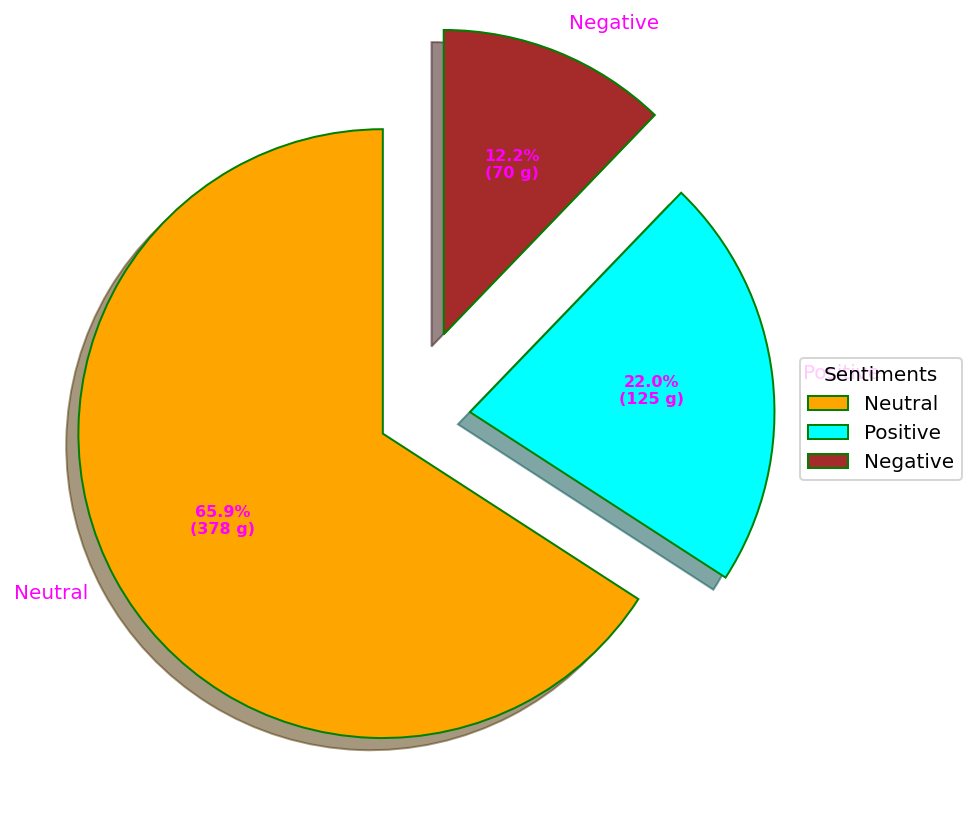

In [673]:
import numpy as np
import matplotlib.pyplot as plt
  
  

sentiment = ['Neutral', 'Positive', 'Negative']
  
data = [neu,pos,neg]
  
  

explode = (0.1, 0.2, 0.3)
  

colors = ( "orange", "cyan", "brown",
          "grey", "indigo", "beige")
  

wp = { 'linewidth' : 1, 'edgecolor' : "green" }
  

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
  
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode, 
                                  labels = sentiment,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="magenta"))
  

ax.legend(wedges, sentiment,
          title ="Sentiments",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("")
  

plt.show()